<a href="https://colab.research.google.com/github/PhingSupanat/Senior_Project/blob/main/Test_Data-Senior_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libaries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from collections import Counter

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style = 'whitegrid',color_codes = True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix,roc_curve, cohen_kappa_score
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc,fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#dl libraraies
from keras import backend as K
from tensorflow.keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

from sklearn.metrics import classification_report
import itertools
from tensorflow import keras
from google.colab.patches import cv2_imshow

In [ ]:
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import sklearn

# Data Preprocessing

In [ ]:
(img_height, img_width) = (299, 299)
batch_size = 32

In [ ]:
def preprocessing_f(no_model):
    if no_model == 1:
        return keras.applications.xception.preprocess_input
    elif no_model == 2:
        return keras.applications.inception_v3.preprocess_input
    elif no_model == 3:
        return keras.applications.vgg19.preprocess_input
    elif no_model == 4:
        return keras.applications.resnet.preprocess_input

def generator_type(g_type, no_model):
    if g_type == 'train':
        return ImageDataGenerator(preprocessing_function = preprocessing_f(no_model),
                                     horizontal_flip = True,
                                     vertical_flip = False,
                                     height_shift_range = 0.05,
                                     width_shift_range = 0.02,
                                     rotation_range = 5,
                                     shear_range = 0.01,
                                     fill_mode = 'nearest',
                                     zoom_range = 0.05)
    else:
        return ImageDataGenerator(preprocessing_function = preprocessing_f(no_model))

def generate_generator_multiple(g_type, dataframe):

    genX1 = generator_type(g_type, 1).flow_from_dataframe(dataframe = dataframe,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)

    genX2 = generator_type(g_type, 2).flow_from_dataframe(dataframe = dataframe,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)
    genX3 = generator_type(g_type, 3).flow_from_dataframe(dataframe = dataframe,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)
    genX4 = generator_type(g_type, 4).flow_from_dataframe(dataframe = dataframe,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        X4i = genX4.next()
        yield [X1i[0], X2i[0], X3i[0], X4i[0]], X2i[1]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.grid(None)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(fpr, tpr, label = None):
    """
    The ROC curve, modified from
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize = (10, 10))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation = 90)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show()

In [ ]:
all_model = ['Xception', 'InceptionV3', 'VGG19', 'ResNet152', 'Ensemble']

In [ ]:
from keras.models import load_model

i = 2
fold = 2

model_name = all_model[i]

if model_name == 'Ensemble':
  model = load_model(f'/content/drive/MyDrive/Project/Model_Save/Lastest_Model/{model_name}_fold_{fold}.h5')
  print(f'Loaded Model: {model_name} Fold: {fold}')
else:
  model = load_model(f'/content/drive/MyDrive/Project/Model_Save/New_Model/{model_name}_fold_{fold}.h5')
  print(f'Loaded Model: {model_name} Fold: {fold}')

Loaded Model: VGG19 Fold: 2


#Valid

In [ ]:
p1 = '/content/drive/MyDrive/Project/C_A1_Naildystrophy'
p2 = '/content/drive/MyDrive/Project/C_A2_Naildystrophy'
p3 = '/content/drive/MyDrive/Project/C_A1_Onychomycosis'
p4 = '/content/drive/MyDrive/Project/C_A2_Onychomycosis'
path1 = pd.Series(os.listdir(p1))
path2 = pd.Series(os.listdir(p2))
path3 = pd.Series(os.listdir(p3))
path4 = pd.Series(os.listdir(p4))

df1 = pd.DataFrame(path1, columns = ['Image_name'])
df1['Image_name'] = p1 + '/' + df1['Image_name']
df2 = pd.DataFrame(path2, columns = ['Image_name'])
df2['Image_name'] = p2 + '/' + df2['Image_name']
df3 = pd.DataFrame(path3, columns = ['Image_name'])
df3['Image_name'] = p3 + '/' + df3['Image_name']
df4 = pd.DataFrame(path4, columns = ['Image_name'])
df4['Image_name'] = p4 + '/' + df4['Image_name']

df = pd.concat([df1, df2, df3, df4])
df['Label'] = np.where(df['Image_name'].str.contains(pat = 'Naildystrophy'), '0', '1')

In [ ]:
# Training with K-fold cross validation
kf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
X = np.array(df['Image_name'])
Y = np.array(df['Label'])

folds = []
train = []
test = []

for fold_no, (train_index, test_index) in enumerate(kf.split(X, Y)):
    print(f"Fold {fold_no+1}:")
    print(f"  Train: index = {train_index}")
    print(f"  Test:  index = {test_index}")
    folds.append(fold_no+1)
    train.append(train_index)
    test.append(test_index)

Fold 1:
  Train: index = [    1     2     3 ... 23211 23213 23214]
  Test:  index = [    0     6    14 ... 23200 23210 23212]
Fold 2:
  Train: index = [    0     1     3 ... 23212 23213 23214]
  Test:  index = [    2     4     8 ... 23204 23206 23208]
Fold 3:
  Train: index = [    0     1     2 ... 23211 23212 23214]
  Test:  index = [   13    21    28 ... 23203 23205 23213]
Fold 4:
  Train: index = [    0     1     2 ... 23212 23213 23214]
  Test:  index = [    3     5     7 ... 23189 23209 23211]
Fold 5:
  Train: index = [    0     2     3 ... 23211 23212 23213]
  Test:  index = [    1    10    11 ... 23202 23207 23214]


In [ ]:
trainData = X[train[fold-1]]
testData = X[test[fold-1]]
## create train, valid dataframe and thus train_gen , valid_gen for each fold-loop
train_df = df.loc[df['Image_name'].isin(list(trainData))]
valid_df = df.loc[df['Image_name'].isin(list(testData))]

if model_name == 'Ensemble':
  valid_gen = generate_generator_multiple('valid', valid_df)
else:
  valid_gen = generator_type('valid', i+1).flow_from_dataframe(dataframe = valid_df,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)

print(f'Validation for fold {folds[fold-1]} ...')

Found 4643 validated image filenames belonging to 2 classes.
Validation for fold 2 ...


145/145 [==============================] - 52s 356ms/step


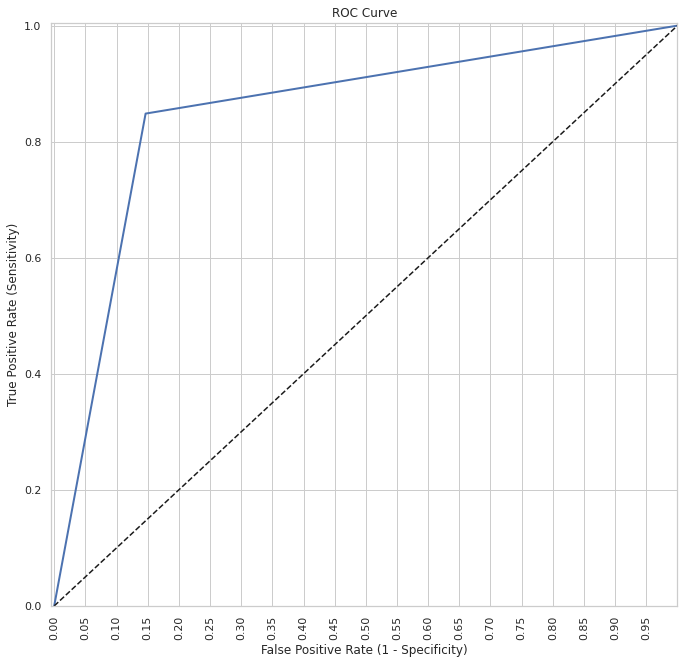

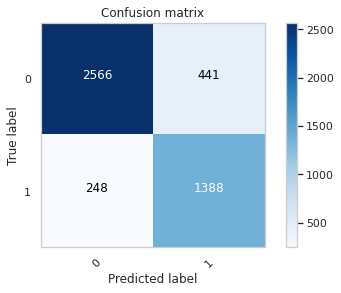

Accuracy:  0.8516045660133534
Recall:  0.8484107579462102
Precision:  0.7588846364133406
Specificity:  0.8533422015297639
F1:  0.8011544011544011
AUC:  0.8508764797379871


In [ ]:
y_pred = model.predict(valid_gen,
                       verbose = 1,
                       steps = len(valid_df)/batch_size)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert validation observations to one hot vectors
y_true = valid_df['Label'].values.tolist()
y_true = list(map(int, y_true))

fpr, tpr, auc_thresholds = roc_curve(y_true, y_pred_classes)
plot_roc_curve(fpr, tpr)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

print('Accuracy: ', accuracy_score(y_true, y_pred_classes))
print('Recall: ', recall_score(y_true, y_pred_classes))
print('Precision: ', precision_score(y_true, y_pred_classes))
print('Specificity: ', recall_score(y_true, y_pred_classes, pos_label = 0))
print('F1: ', fbeta_score(y_true, y_pred_classes, beta = 1))
print('AUC: ', roc_auc_score(y_true, y_pred_classes))

-------------------------------------------------------------------
Beta = 2
Best Threshold = 0.23895305395126342773, F2.00-score = 0.8611


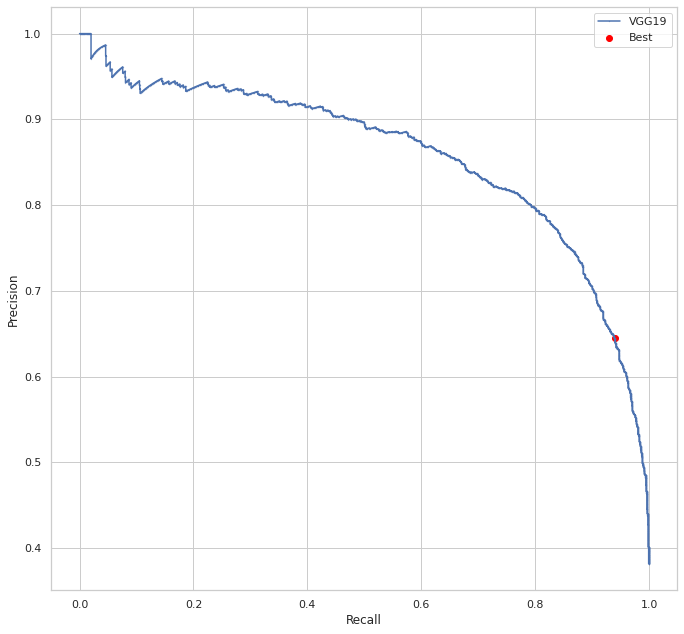

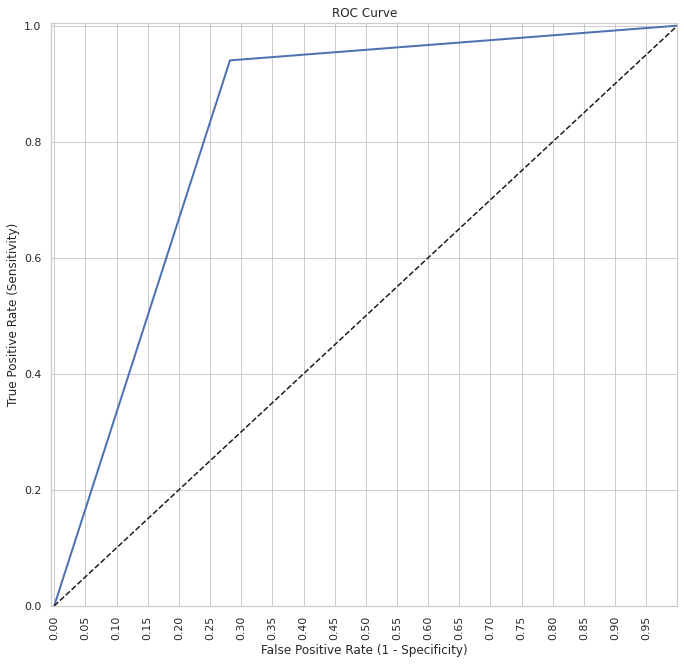

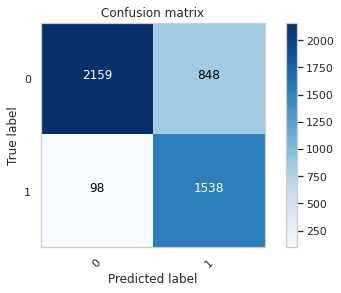

Accuracy_th:  0.7962524230023692
Recall_th:  0.9400977995110025
Precision_th:  0.644593461860855
Specificity_th:  0.7179913535084802
Fbeta_th:  0.8611422172452408
AUC_th:  0.8290445765097413


In [ ]:
#Threshold Optimization
y_pred_1 = y_pred[:, 1]

pre, rec, th = precision_recall_curve(y_true, y_pred_1)
beta = [2]

for b in beta:

  print('-------------------------------------------------------------------')
  print(f'Beta = {b}')
  fscore = ((1 + b**2)*pre*rec)/((b**2)*pre + rec)

  ix = np.argmax(fscore)
  print('Best Threshold = %.20f, F%.2f-score = %.4f' % (th[ix], b, fscore[ix]))
  # plot the roc curve for the model
  plt.figure(figsize = (10, 10))
  plt.plot(rec, pre, marker = '.', label = model_name, markersize = 0.5)
  plt.scatter(rec[ix], pre[ix], marker = 'o', color = 'red', label = 'Best')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

  optimal_proba_cutoff = th[ix]
  roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_pred[:, -1]]
  fpr, tpr, auc_thresholds = roc_curve(y_true, roc_predictions)
  plot_roc_curve(fpr, tpr)

  confusion_mtx = confusion_matrix(y_true, roc_predictions)
  plot_confusion_matrix(confusion_mtx, classes = range(2))

  print('Accuracy_th: ', accuracy_score(y_true, roc_predictions))
  print('Recall_th: ', recall_score(y_true, roc_predictions))
  print('Precision_th: ', precision_score(y_true, roc_predictions))
  print('Specificity_th: ', recall_score(y_true,  roc_predictions, pos_label = 0))
  print('Fbeta_th: ', fbeta_score(y_true, roc_predictions, beta = b))
  print('AUC_th: ', roc_auc_score(y_true, roc_predictions))

#Test

In [ ]:
p1 = '/content/drive/MyDrive/Project/Open_Data/Naildystrophy'
p2 = '/content/drive/MyDrive/Project/Open_Data/Onychomycosis'
p3 = '/content/drive/MyDrive/Project/Test_Data/Onychomycosis_dermatophyte'
p4 = '/content/drive/MyDrive/Project/Test_Data/Onychomycosis_non-dermatophyte'

path1 = pd.Series(os.listdir(p1))
path2 = pd.Series(os.listdir(p2))
path3 = pd.Series(os.listdir(p3))
path4 = pd.Series(os.listdir(p4))

df1 = pd.DataFrame(path1, columns = ['Image_name'])
df1['Image_name'] = p1 + '/' + df1['Image_name']
df2 = pd.DataFrame(path2, columns = ['Image_name'])
df2['Image_name'] = p2 + '/' + df2['Image_name']
df3 = pd.DataFrame(path3, columns = ['Image_name'])
df3['Image_name'] = p3 + '/' + df3['Image_name']
df4 = pd.DataFrame(path4, columns = ['Image_name'])
df4['Image_name'] = p4 + '/' + df4['Image_name']

df_test = pd.concat([df1, df2, df3, df4])
df_test['Label'] = np.where(df_test['Image_name'].str.contains(pat = 'Naildystrophy'), '0', '1')

In [ ]:
if model_name == 'Ensemble':
  test_gen =  generate_generator_multiple('test', df_test)
else:
  test_gen = generator_type('test', i+1).flow_from_dataframe(dataframe = df_test,
                                         directory = None,
                                         x_col = 'Image_name',
                                         y_col = 'Label',
                                         class_mode = 'sparse',
                                         classes = ['0', '1'],
                                         shuffle = False,
                                         target_size = (img_height, img_width),
                                         color_mode = 'rgb',
                                         batch_size = batch_size,
                                         seed = 42)

Found 1512 validated image filenames belonging to 2 classes.


In [ ]:
#test 1
y_pred = model.predict(test_gen,
                       verbose = 1,
                       steps = len(df_test)/batch_size)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert validation observations to one hot vectors
y_true = df_test['Label'].values.tolist()
y_true = list(map(int, y_true))

47/47 [==============================] - 31s 661ms/step


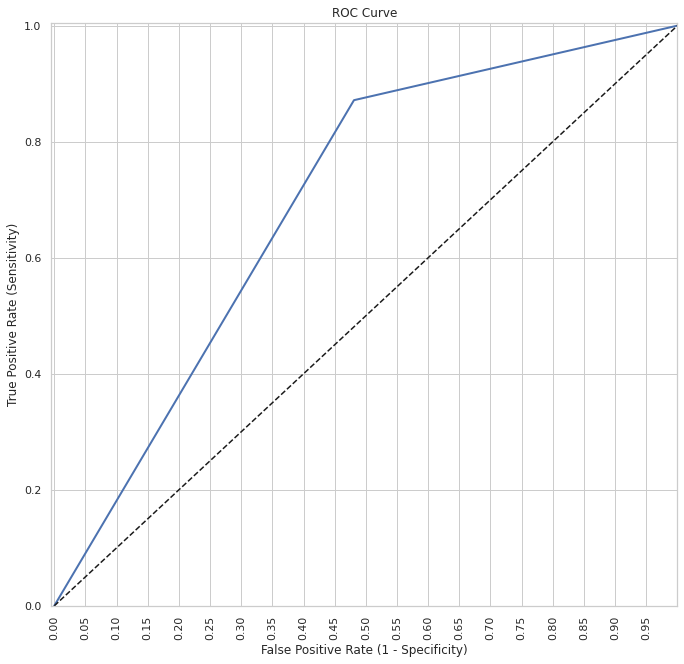

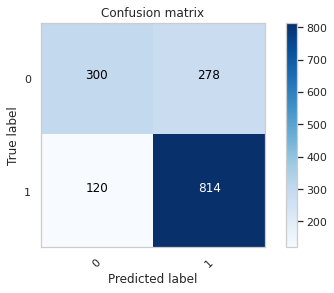

Accuracy_th:  0.7367724867724867
Recall_th:  0.8715203426124197
Precision_th:  0.7454212454212454
Specificity_th:  0.5190311418685121
Fbeta_th:  0.8429991714995858
AUC_th:  0.6952757422404658
Accuracy (C Dataset): 0.6688311688311688


In [ ]:
op_th = th[ix]

roc_predictions = [1 if i >= op_th else 0 for i in y_pred[:, -1]]
fpr, tpr, auc_thresholds = roc_curve(y_true, roc_predictions)
plot_roc_curve(fpr, tpr)

confusion_mtx = confusion_matrix(y_true, roc_predictions)
plot_confusion_matrix(confusion_mtx, classes = range(2))

result = pd.DataFrame({'File Name': df_test['Image_name'],
                       'Actual Class': y_true,
                       'Predicted Class': roc_predictions,
                       'Class 0 Probability ': y_pred[:, 0],
                       'Class 1 Probability ': y_pred[:, 1]})
result['Correct'] = np.where(result['Actual Class'] == result['Predicted Class'], 'Yes', 'No')

Test = result[result['File Name'].str.contains(pat = 'Test_Data') == True]
Correct = Test[Test['Correct'] == 'Yes'].shape[0] / Test.shape[0]

print('Accuracy_th: ', accuracy_score(y_true, roc_predictions))
print('Recall_th: ', recall_score(y_true, roc_predictions))
print('Precision_th: ', precision_score(y_true, roc_predictions))
print('Specificity_th: ', recall_score(y_true,  roc_predictions, pos_label = 0))
print('Fbeta_th: ', fbeta_score(y_true, roc_predictions, beta = 2))
print('AUC_th: ', roc_auc_score(y_true, roc_predictions))
print(f'Accuracy (C Dataset): {Correct}')

In [ ]:
'''Test_No = Test[Test['Correct'] == 'No']
for i in Test_No['File Name'].values.tolist()[:10]:
  print(i)
  img = cv2.imread(i)
  imS = cv2.resize(img, (300, 300))
  cv2_imshow(imS)'''

"Test_No = Test[Test['Correct'] == 'No']\nfor i in Test_No['File Name'].values.tolist()[:10]:\n  print(i)\n  img = cv2.imread(i)\n  imS = cv2.resize(img, (300, 300))  \n  cv2_imshow(imS)"

In [ ]:
'''(img_height, img_width) = (299, 299)
batch_size = 32
epochs = 100

red_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 1,factor = 0.1)
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, restore_best_weights = True)

train_class_weights = sklearn.utils.class_weight.compute_class_weight(
                                            class_weight = 'balanced',
                                            classes = ['0','1'],
                                            y = train_df['Label'].values.tolist())
class_weight = dict(enumerate(train_class_weights))
print(class_weight)

History = model.fit(
            train_gen,
            steps_per_epoch = train_gen.n//batch_size,
            epochs = epochs,
            validation_data = valid_gen,
            validation_steps = valid_gen.n//batch_size,
            class_weight = class_weight,
            callbacks = [red_lr, early_stop])'''

"(img_height, img_width) = (299, 299)\nbatch_size = 32\nepochs = 100\n\nred_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 1,factor = 0.1)\nearly_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, restore_best_weights = True)\n\ntrain_class_weights = sklearn.utils.class_weight.compute_class_weight(\n                                            class_weight = 'balanced',\n                                            classes = ['0','1'], \n                                            y = train_df['Label'].values.tolist())\nclass_weight = dict(enumerate(train_class_weights))\nprint(class_weight)\n    \nHistory = model.fit(\n            train_gen,\n            steps_per_epoch = train_gen.n//batch_size,\n            epochs = epochs,\n            validation_data = valid_gen,\n            validation_steps = valid_gen.n//batch_size,\n            class_weight = class_weight,\n            callbacks = [red_lr, early_stop])"